In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import loadTDT as tdt
from scipy import signal
from scipy.signal import detrend
from scipy.signal import resample
from scipy.signal import medfilt
from scipy.signal import butter
from scipy.signal import filtfilt
from statsmodels import robust
from scipy import ndimage, misc
from scipy.ndimage import gaussian_filter1d
import pims
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
from scipy.stats import entropy
sns.set_context("paper")

In [12]:
from util import *
from behavior_utils import *

In [29]:
ggp=np.array([[0.133     , 0.133     , 0.133     , 1.        ],
       [0.22953434, 0.57685998, 0.42976558, 1.        ],
       [0.57609486, 0.42953354, 0.90002989, 1.        ]])
pal2=[(ggp[1][0],ggp[1][1],ggp[1][2]),
       (ggp[2][0],ggp[2][1],ggp[2][2])]

## All advanced analysis for behavioral analysis of opto cohorts

In [3]:
## Anna data both vglut cohorts (selective based on histology)
groups={'vglut all':[687,681,663,664,676,674,684,686,677,688,627],
        'no opsin control all':[644,636,621,622,624,640,678,660,662,685,679]}
#ppal=['yellowgreen','hotpink','grey','dodgerblue']
ppal=['dodgerblue','grey']
#pord=['vglut','wt','no opsin control','no light control']
pord=['vglut all','no opsin control all']

# recording frame rate
FS=100

In [4]:
## Add NpHr
groups_NpHr={'NpHr':[4401,4402,4403,4411,4412,4416,4417,4418,4419,4420],
        'YFP':[4404,4405,4406,4407,4408,4409,4410,4413,4414,4415]}
ppal_NpHr=['gold','grey']
pord_NpHr=['NpHr','YFP']

In [22]:
r2s = [677,
627,
688,
663,
664,
684,
676,
686,
674,
687,
681]

SI_values = [0,
19.89766667,
24.12413333,
30.84196667,
36.748,
36.79233333,
40.90766667,
43.54366667,
45.33433333,
53.153,
55.36633333]

RFCUTOFF = 7

r2s_all = [677,
627,
688,
663,
664,
684,
676,
686,
674,
687,
681,
622,
636,
678,
685,
662,
644,
624,
660,
640,
679,
621]

SI_values_all = [0,
19.89766667,
24.12413333,
30.84196667,
36.748,
36.79233333,
40.90766667,
43.54366667,
45.33433333,
53.153,
55.36633333,
30.94206667,
33.0108,
37.24833333,
39.06133333,
42.498,
49.694,
51.229,
55.133,
58.792,
61.53933333,
78.28933333]

RFCUTOFF_all = 11

metadat=pd.read_csv('/jukebox/witten/Anna/fig_data_plotting_code/QuantifyingDefeat-main/si_sucrose_tt_anna_opto.csv')

In [36]:
SI_values_NpHr = [6.328566667,
11.07773333,
26.08163333,
26.73783333,
27.4719,
27.70546667,
35.06833333,
36.15833333,
43.677,
65.866,
16.28293333,
17.33956667,
23.90166667,
29.8187,
38.316,
44.678,
45.501,
47.55866667,
63.152,
70.57066667]

r2s_NpHr = [4415,
4413,
4404,
4414,
4410,
4407,
4406,
4405,
4409,
4408,
4418,
4419,
4417,
4412,
4416,
4411,
4401,
4403,
4420,
4402]

RFCUTOFF_nphr = 10

metadat_nphr=pd.read_csv('/jukebox/witten/Anna/fig_data_plotting_code/QuantifyingDefeat-main/si_sucrose_tt_anna_nphr.csv')

In [7]:
def analyze_dlc(dlcfile):
    dlcdat = pd.read_csv(dlcfile,header=[1,2])
    body_parts =list(dlcdat.columns.levels[0])[:-1]

    v_kernal=13

    bp2traces={}
    for i,bp in enumerate(body_parts):
        if 'Top' in bp and 'Tip' not in bp and 'Divider' not in bp:
            xy= np.array(dlcdat[bp][['x','y']])
            bp2traces[bp]=np.array([medfilt(xy[:,0],v_kernal),medfilt(xy[:,1],v_kernal)])
            dists = np.linalg.norm(xy[:-1]-xy[1:],axis=1)
            
        if 'Nose' in bp or 'Fiber' in bp:
            xy= np.array(dlcdat[bp][['x','y']])
            bp2traces[bp]=np.array([medfilt(xy[:,0],v_kernal),medfilt(xy[:,1],v_kernal)])
            dists = np.linalg.norm(xy[:-1]-xy[1:],axis=1)


    # Centroid per mouse
    bp2traces['TopBLCentroid']=np.array([np.mean([bp2traces['TopBLTTI'][0],bp2traces['TopBLNose'][0]],axis=0),
                                        np.mean([bp2traces['TopBLTTI'][1],bp2traces['TopBLNose'][1]],axis=0)])
    bp2traces['TopSWCentroid']=np.array([np.mean([bp2traces['TopSWTTI'][0],bp2traces['TopSWNose'][0]],axis=0),
                                        np.mean([bp2traces['TopSWTTI'][1],bp2traces['TopSWNose'][1]],axis=0)])
    # Centroid velocity per mouse
    bp2traces['TopBLCentroidVelocity']=medfilt(np.linalg.norm(bp2traces['TopBLCentroid'][:,10:]-
                                                              bp2traces['TopBLCentroid'][:,:-10],axis=0),v_kernal)
    bp2traces['TopSWCentroidVelocity']=medfilt(np.linalg.norm(bp2traces['TopSWCentroid'][:,10:]-
                                                              bp2traces['TopSWCentroid'][:,:-10],axis=0),v_kernal)

    # Velocty per joint



    # Distance between mice
    bp2traces['TopBetweenCentroidDistance']=medfilt(np.linalg.norm(bp2traces['TopBLCentroid']-
                                                              bp2traces['TopSWCentroid'],axis=0),v_kernal)
    # Velocity between mice
    bp2traces['TopBetweenCentroidVelocity']=medfilt(bp2traces['TopBetweenCentroidDistance'][10:]-
                                                              bp2traces['TopBetweenCentroidDistance'][:-10],
                                                    v_kernal)


    # Orientation = (tail2othercentroid-head2othercentroid)/(headtotail) [-1 is facing away, 1 is facing toward]
    bp2traces['TopSWtoBL'] = (np.linalg.norm(bp2traces['TopSWTTI']-bp2traces['TopBLCentroid'],axis=0)-
                              np.linalg.norm(bp2traces['TopSWNose']-bp2traces['TopBLCentroid'],axis=0))/np.abs((np.linalg.norm(bp2traces['TopSWNose']-bp2traces['TopSWTTI'],axis=0)))
    bp2traces['TopBLtoSW'] = (np.linalg.norm(bp2traces['TopBLTTI']-bp2traces['TopSWCentroid'],axis=0)-
                              np.linalg.norm(bp2traces['TopBLNose']-bp2traces['TopSWCentroid'],axis=0))/np.abs((np.linalg.norm(bp2traces['TopBLNose']-bp2traces['TopBLTTI'],axis=0)))


    # Angle between mice
    nose_offsets = bp2traces['TopBLNose']-bp2traces['TopSWNose']
    SWTTI_translated=bp2traces['TopSWTTI']+nose_offsets
    ba=bp2traces['TopBLTTI']-bp2traces['TopBLNose']
    bc=SWTTI_translated-bp2traces['TopBLNose']
    cosine_angle = np.sum(ba* bc,axis=0) / (np.linalg.norm(ba,axis=0) * np.linalg.norm(bc,axis=0))
    angle = np.rad2deg(np.arccos(cosine_angle))
    
    
    return bp2traces

In [13]:
# save aldat_all
import pickle
#pickle.dump(alldat_nphr, open("alldat_NpHr.p","wb"))
alldat_all = pickle.load(open('alldat_opto_all.p','rb'),encoding='latin')
alldat_nphr = pickle.load(open('alldat_nphr.p','rb'),encoding='latin')
#embeddings= pickle.load(open('embeddings2.p','rb'),encoding='latin')

In [8]:
## add vglut cohort 2 data
#session2feats = pickle.load(open('/jukebox/witten/Anna/fig_data_plotting_code/QuantifyingDefeat-main/QuantifyBehavior/features_opto_vglut_cohort2.p','rb'))
session2feats = pickle.load(open('features_opto_vglut_cohort2.p','rb'))
#session2feats_2 = pickle.load(open('/jukebox/witten/Anna/fig_data_plotting_code/QuantifyingDefeat-main/QuantifyBehavior/features_opto_vglut_cohort1.p','rb'))
session2feats_2 = pickle.load(open('features_opto_vglut_cohort1.p','rb'))

def Merge(dict1, dict2):
    return(dict2.update(dict1))

Merge(session2feats_2,session2feats)

sessions = list(session2feats.keys())

# add extracted features to alldat 
for k in session2feats.keys():
    m = k[1:4]
    if k == 'm675_csds1':
        continue
    elif k == 'm685_csds':
        d = 10
    elif len(k) > 10:
        d = k[9:11]
        #print('10')
        #print(k)
    else:
        #print(k)
        #print('<10')
        d = k[9]
    alldat_all[(int(m),int(d))]['extracted_features'] = session2feats[k]

In [26]:
## add vglut cohort 2 data
#session2feats = pickle.load(open('/jukebox/witten/Anna/fig_data_plotting_code/QuantifyingDefeat-main/QuantifyBehavior/features2_nphr.p','rb'))
session2feats = pickle.load(open('features2_nphr.p','rb'))

sessions = list(session2feats.keys())

# add extracted features to alldat 
for k in session2feats.keys():
    m = k[1:5]
    if len(k) > 11:
        d = k[10:12]
        #print('10')
        #print(k)
    else:
        #print(k)
        #print('<10')
        d = k[10]
    alldat_nphr[(int(m),int(d))]['extracted_features'] = session2feats[k]

In [23]:
#rf_anna_OPTO_BOTH_new = pickle.load(open('/jukebox/witten/Anna/fig_data_plotting_code/QuantifyingDefeat-main/QuantifyBehavior/rf_scores_newoptoONLY.p','rb'),encoding='latin')
#rf_anna_OPTO_BOTH_new = pickle.load(open('/jukebox/witten/Anna/fig_data_plotting_code/QuantifyingDefeat-main/QuantifyBehavior/rf_scores_newopto2andFP_BOTHCOHORTS.p','rb'),encoding='latin')
rf_anna_OPTO_BOTH_new = pickle.load(open('rf_scores_newopto2andFP_BOTHCOHORTS.p','rb'),encoding='latin')

#behaviors = ['e','a','x','s','z','i','t','f','d','w','p','r']
#behaviors = ['e','a','x','s','z','i','t','f','d','w','p']
behaviors = ['e','a','x','s','i','f','u','z']
rf_scores_OPTO_BOTH_new = {}
for k in rf_anna_OPTO_BOTH_new.keys():
    if k[1] == '6':
        m = int(k[1:4])
        if k[9] != '0':
            d = int(k[9:11])
        else:
            d = int(k[9])
        rf_scores_OPTO_BOTH_new[m,d] = {}
        for b in behaviors:
            rf_scores_OPTO_BOTH_new[m,d][b]=rf_anna_OPTO_BOTH_new[k][b]

In [15]:
#rf_anna_nphr = pickle.load(open('/jukebox/witten/Anna/Social_Defeat/RF/rf_scores_NpHR.p','rb'),encoding='latin')
#rf_anna_nphr = pickle.load(open('/jukebox/witten/Anna/fig_data_plotting_code/QuantifyingDefeat-main/QuantifyBehavior/rf_scores_nphr_FPandChR.p','rb'),encoding='latin')
rf_anna_nphr = pickle.load(open('rf_scores_nphr_FPandChR.p','rb'),encoding='latin')

#behaviors = ['e','a','x','s','z','i','t','f','d','w','p','r']
#behaviors = ['e','a','x','s','z','i','t','f','d','w','p']
behaviors = ['e','a','x','s','i','f','u','z']
rf_scores_nphr = {}
for k in rf_anna_nphr.keys():
#     m = int(k[0][1:5])
#     d = int(k[1])
#     rf_scores_nphr[m,d] = {}
#     for b in behaviors:
#         rf_scores_nphr[m,d][b]=rf_anna_nphr[k][b]
    m = int(k[1:5])
    if len(k)<12:
        d = int(k[10])
    else:
        d = int(k[10:12])
    rf_scores_nphr[m,d] = {}
    for b in behaviors:
        rf_scores_nphr[m,d][b]=rf_anna_nphr[k][b]



In [58]:
## Run this for labeled using only opto

FS = 100
total_time = 5*60*FS
rf_totals = {'m':[],'d':[],'t':[],'b':[],'r2s':[],'rb':[]}
fight_check = {'m':[],'d':[],'r2s':[],'rb':[],'F':[],'T':[],'f':[],'a':[],'si':[],'r':[],'R':[]}
for i,m in enumerate(r2s_all):
    for d in range(1,11):
        if (m,d) not in rf_scores_OPTO_BOTH_new:
            continue
        rf=rf_scores_OPTO_BOTH_new[(m,d)]
        for b,l in rf.items():
            t=l
            rf_totals['b'].append(b)
            rf_totals['m'].append(str(m))
            rf_totals['d'].append(d)
            #rf_totals['t'].append(np.sum(t)/len(t))
            rf_totals['t'].append(np.sum(t)/total_time)
            rf_totals['r2s'].append(i)
            rf_totals['rb'].append(i>=RFCUTOFF_all)
        #a=rf['attack']
        a=rf['a']
        #b=np.logical_and(a,rf['fightback'])
        b=np.logical_and(a,rf['f'])
        rf_totals['b'].append('fightWhenAttacked')
        #rf_totals['b'].append('f')
        rf_totals['m'].append(str(m))
        rf_totals['d'].append(d)
        rf_totals['t'].append(np.sum(b)/np.sum(a))
        rf_totals['r2s'].append(i)
        rf_totals['rb'].append(i>=RFCUTOFF_all)
        
        #a=rf['attack']
        a=rf['a']
        #b=np.logical_and(a,rf['runaway'])
        b=np.logical_and(a,rf['x'])
        rf_totals['b'].append('fleeWhenAttacked')
        #rf_totals['b'].append('x')
        rf_totals['m'].append(str(m))
        rf_totals['d'].append(d)
        rf_totals['t'].append(np.sum(b)/np.sum(a))
        rf_totals['r2s'].append(i)
        rf_totals['rb'].append(i>=RFCUTOFF_all)
        
        #a=rf['attack']
        a=rf['a']
        #b=np.logical_and(a,rf['runaway'])
        b=np.logical_and(a,rf['z'])
        rf_totals['b'].append('freezeWhenAttacked')
        #rf_totals['b'].append('x')
        rf_totals['m'].append(str(m))
        rf_totals['d'].append(d)
        rf_totals['t'].append(np.sum(b)/np.sum(a))
        rf_totals['r2s'].append(i)
        rf_totals['rb'].append(i>=RFCUTOFF_all)

        
        fight_check['m'].append(str(m))
        fight_check['d'].append(d)
        fight_check['r2s'].append(i)
        fight_check['rb'].append(i>=RFCUTOFF_all)
        #fight_check['F'].append(np.sum(rf['fightback']))
        fight_check['F'].append(np.sum(rf['f']))
        fight_check['T'].append(len(t))
        #fight_check['f'].append(np.sum(np.logical_and(rf['attack'],rf['fightback'])))
        fight_check['f'].append(np.sum(np.logical_and(rf['a'],rf['f'])))
        #fight_check['a'].append(np.sum(rf['attack']))
        fight_check['a'].append(np.sum(rf['a']))
        fight_check['si'].append(SI_values_all[i])
        #fight_check['R'].append(np.sum(rf['runaway']))
        fight_check['R'].append(np.sum(rf['x']))
        #fight_check['r'].append(np.sum(np.logical_and(rf['attack'],rf['runaway'])))
        fight_check['r'].append(np.sum(np.logical_and(rf['a'],rf['x'])))
        
fight_check_df=pd.DataFrame(fight_check)
rf_df=pd.DataFrame(rf_totals)
rf_df.m=rf_df.m.astype(int)
rf_df = pd.merge(metadat,rf_df,left_on='Mouse',right_on='m')

/usr/people/az3/.conda/envs/RF_anna/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/people/az3/.conda/envs/RF_anna/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/mnt/cup/labs/witten/Anna/fig_data_plotting_code/QuantifyingDefeat-main/FigureAnalysis/util.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

220
11 11
being attacked 1 0.24597256570584275 0.8082101692413319
11 11
being attacked 2 -2.187821166662049 0.040725749859035716
11 11
being attacked 3 -0.25154635726302854 0.8039583344577379
11 11
being attacked 4 -0.9903240670964752 0.33384660680537215
11 11
being attacked 5 -0.8629542450232252 0.39839300255442667
11 11
being attacked 6 -0.6394899665071093 0.5297616950249764
11 11
being attacked 7 1.0735552623132028 0.29580477521066156
11 11
being attacked 8 -2.054452443065134 0.05323329508571262
11 11
being attacked 9 0.2921872307283706 0.7731529283089371
11 11
being attacked 10 -1.2730998432913294 0.21758237427924618
being attacked [False False False False False False False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  220
Model:                                 GEE   No. clusters:                       22
Method:                        Generalized

11 11
fleeing while attacked 5 1.7120304585524926 0.10235474005357854
11 11
fleeing while attacked 6 3.6759380995288855 0.001498876828494241
11 11
fleeing while attacked 7 2.966931767711467 0.007621947096695835
11 11
fleeing while attacked 8 4.930642934049261 8.062411296181527e-05
11 11
fleeing while attacked 9 4.30653086306251 0.0003435822591935329
11 11
fleeing while attacked 10 4.226814074527764 0.00041393904219700907
fleeing while attacked [ True  True  True  True False  True  True  True  True  True]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  220
Model:                                 GEE   No. clusters:                       22
Method:                        Generalized   Min. cluster size:                  10
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:       

<Figure size 1000x1000 with 0 Axes>

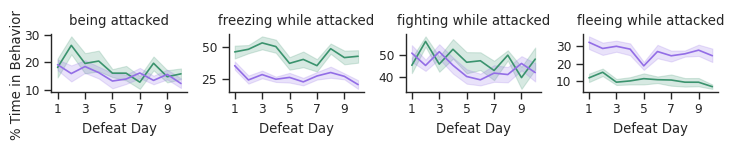

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  220
Model:                                 GEE   No. clusters:                       22
Method:                        Generalized   Min. cluster size:                  10
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                10.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Sun, 19 May 2024   Scale:                          77.557
Covariance type:                    robust   Time:                         23:41:44
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.5902      2.219      9.280      0.000      16.241      24.939
si     

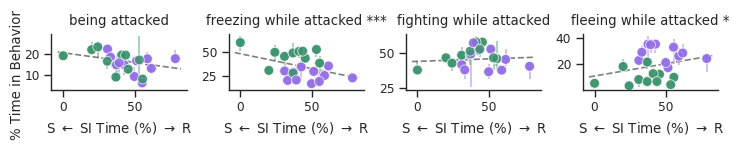

In [59]:
# b2tdict={'attack':'being attacked',
#      'standing against wall':'standing against wall',
#      'fightback':'fighting',
#      'runaway':'fleeing',
#      'sniffing':'being investigated',
#      'freezing':'immobile',
#      'approach':'approaching aggressor',
#      'fightWhenAttacked':'fighting while attacked',
#      'fightWhenNotAttacked': 'fighting while not attacked',
#      'notAttackedWhenFight':'not attacked while fighting',
#       'fleeWhenAttacked':'fleeing while attacked',
#      'freezeWhenAttacked':'immobile while attacked',
#       'fleeWhenSniffed':'fleeing while sniffed',
#      'freezeWhenSniffed':'immobile while sniffed',
#       'fightWhenSniffed':'fighting while sniffed',
#        'fleeWhenNotAttackedOrSniffed':'fleeing while not attacked or sniffed',
#      'freezeWhenNotAttackedOrSniffed':'immobile while not attacked or sniffed',
#       'fightWhenNotAttackedOrSniffed':'fighting while not attacked or sniffed',
#         'attackWhenNotFightOrFlee':'not fighting or fleeing while attacked',
#      'fightToFleeRatio': 'fight vs flee'}
b2tdict={'a':'being attacked',
     #'attack':'attacked2',
     'w':'standing against wall',
     'f':'fightback',
     'x':'runaway',
     's':'being investigated',
     #'sniffing':'sniffed2',
     'z':'freezing',
     'e':'approach',
     'i':'investigate aggressor',
     't':'tail rattle',
     'r':'rattle',
     'b':'barrier',
     'd':'defense',
     'p':'pursued',
     'u':'vigilant',
     'freezeWhenAttacked':'freezing while attacked',
     'fightWhenAttacked':'fighting while attacked',
     'fleeWhenAttacked':'fleeing while attacked'}

#border=['a','s','f','x']
border=['a','freezeWhenAttacked','fightWhenAttacked','fleeWhenAttacked']
#border=['attack','sniffing','fightWhenAttacked','fleeWhenAttacked']
rf_df_plot=rf_df
rf_df_plot['c']=[b2tdict[b] for b in rf_df_plot.b.values]
rf_df_plot['si']= [SI_values_all[i] for i in rf_df_plot.r2s.values]
rf_df_plot=rf_df_plot.query('b in %s'%(border))
rf_df_plot['t']=rf_df_plot['t']*100
rf_df_plot['sex']='male'

rf_summary=make_behavior_plots(rf_df_plot,offset=0.5,order=[b2tdict[b] for b in border],
                    ylabel='% Time in Behavior',aspect=0.83,height=1.5)

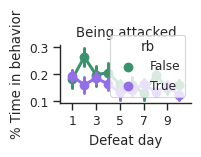

In [64]:
fig, axes = plt.subplots(1, 1, figsize=(2.1, 1.5), sharey=False)
sns.pointplot(data=rf_df.loc[(rf_df['b']=='a')], x="d", y="t", hue="rb",ci=68,palette=pal2,markersize=20,legend=True,)
plt.xlabel('Defeat day')
plt.ylabel('% Time in behavior',va='bottom')
plt.xticks(np.arange(0,10,step=2))
plt.xlim(-1,10)
plt.title('Being attacked')
sns.despine()
plt.savefig('rf_attackvsday_Chr2.pdf',transparent=True,dpi=300,
                    bbox_inches='tight')

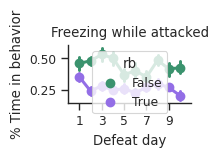

In [65]:
fig, axes = plt.subplots(1, 1, figsize=(2.1, 1.5), sharey=False)
sns.pointplot(data=rf_df.loc[(rf_df['b']=='freezeWhenAttacked')], x="d", y="t", hue="rb",ci=68,palette=pal2,markersize=20,legend=True,)
plt.xlabel('Defeat day')
plt.ylabel('% Time in behavior',va='bottom')
plt.xticks(np.arange(0,10,step=2))
plt.xlim(-1,10)
plt.title('Freezing while attacked')
sns.despine()
plt.savefig('rf_freezevsday_ChR2.pdf',transparent=True,dpi=300,
                    bbox_inches='tight')

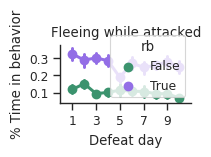

In [66]:
fig, axes = plt.subplots(1, 1, figsize=(2.1, 1.5), sharey=False)
sns.pointplot(data=rf_df.loc[(rf_df['b']=='fleeWhenAttacked')], x="d", y="t", hue="rb",ci=68,palette=pal2,markersize=20,legend=True,)
plt.xlabel('Defeat day')
plt.ylabel('% Time in behavior',va='bottom')
plt.xticks(np.arange(0,10,step=2))
plt.xlim(-1,10)
plt.title('Fleeing while attacked')
sns.despine()
plt.savefig('rf_fleevsday_ChR2.pdf',transparent=True,dpi=300,
                    bbox_inches='tight')

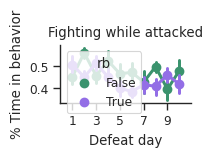

In [67]:
fig, axes = plt.subplots(1, 1, figsize=(2.1, 1.5), sharey=False)
sns.pointplot(data=rf_df.loc[(rf_df['b']=='fightWhenAttacked')], x="d", y="t", hue="rb",ci=68,palette=pal2,markersize=20,legend=True,)
plt.xlabel('Defeat day')
plt.ylabel('% Time in behavior',va='bottom')
plt.xticks(np.arange(0,10,step=2))
plt.xlim(-1,10)
plt.title('Fighting while attacked')
sns.despine()
plt.savefig('rf_fightvsday_ChR2.pdf',transparent=True,dpi=300,
                    bbox_inches='tight')

In [37]:
rf_totals = {'m':[],'d':[],'t':[],'b':[],'r2s':[],'rb':[]}
fight_check = {'m':[],'d':[],'r2s':[],'rb':[],'F':[],'T':[],'f':[],'a':[],'si':[],'r':[],'R':[]}
total_time = 5*60*FS
for i,m in enumerate(r2s_NpHr):
    for d in range(1,11):
        if (m,d) not in rf_scores_nphr:
            print(m,d)
            continue
        rf=rf_scores_nphr[(m,d)]
        for b,l in rf.items():
            t=l
            rf_totals['b'].append(b)
            rf_totals['m'].append(str(m))
            rf_totals['d'].append(d)
            #rf_totals['t'].append(np.sum(t)/len(t))
            rf_totals['t'].append(np.sum(t)/total_time)
            rf_totals['r2s'].append(i)
            rf_totals['rb'].append(i>=RFCUTOFF_nphr)
        #a=rf['attack']
        a=rf['a']
        #b=np.logical_and(a,rf['fightback'])
        b=np.logical_and(a,rf['f'])
        rf_totals['b'].append('fightWhenAttacked')
        #rf_totals['b'].append('f')
        rf_totals['m'].append(str(m))
        rf_totals['d'].append(d)
        if np.sum(a) == 0:
            rf_totals['t'].append(np.sum(a))
        else:
            rf_totals['t'].append(np.sum(b)/np.sum(a))
        rf_totals['r2s'].append(i)
        rf_totals['rb'].append(i>=RFCUTOFF_nphr)
        
        #a=rf['attack']
        a=rf['a']
        #b=np.logical_and(a,rf['runaway'])
        b=np.logical_and(a,rf['x'])
        rf_totals['b'].append('fleeWhenAttacked')
        #rf_totals['b'].append('x')
        rf_totals['m'].append(str(m))
        rf_totals['d'].append(d)
        if np.sum(a) == 0:
            rf_totals['t'].append(np.sum(a))
        else:
            rf_totals['t'].append(np.sum(b)/np.sum(a))
        rf_totals['r2s'].append(i)
        rf_totals['rb'].append(i>=RFCUTOFF_nphr)
        
        #a=rf['attack']
        a=rf['a']
        #b=np.logical_and(a,rf['runaway'])
        b=np.logical_and(a,rf['z'])
        rf_totals['b'].append('freezeWhenAttacked')
        #rf_totals['b'].append('x')
        rf_totals['m'].append(str(m))
        rf_totals['d'].append(d)
        if np.sum(a) == 0:
            rf_totals['t'].append(np.sum(a))
        else:
            rf_totals['t'].append(np.sum(b)/np.sum(a))
        rf_totals['r2s'].append(i)
        rf_totals['rb'].append(i>=RFCUTOFF_nphr)

        fight_check['m'].append(str(m))
        fight_check['d'].append(d)
        fight_check['r2s'].append(i)
        fight_check['rb'].append(i>=RFCUTOFF_nphr)
        #fight_check['F'].append(np.sum(rf['fightback']))
        fight_check['F'].append(np.sum(rf['f']))
        fight_check['T'].append(len(t))
        #fight_check['f'].append(np.sum(np.logical_and(rf['attack'],rf['fightback'])))
        fight_check['f'].append(np.sum(np.logical_and(rf['a'],rf['f'])))
        #fight_check['a'].append(np.sum(rf['attack']))
        fight_check['a'].append(np.sum(rf['a']))
        fight_check['si'].append(SI_values_NpHr[i])
        #fight_check['R'].append(np.sum(rf['runaway']))
        fight_check['R'].append(np.sum(rf['x']))
        #fight_check['r'].append(np.sum(np.logical_and(rf['attack'],rf['runaway'])))
        fight_check['r'].append(np.sum(np.logical_and(rf['a'],rf['x'])))
        
fight_check_df=pd.DataFrame(fight_check)
rf_df=pd.DataFrame(rf_totals)
rf_df.m=rf_df.m.astype(int)
rf_df = pd.merge(metadat_nphr,rf_df,left_on='Mouse',right_on='m')

/usr/people/az3/.conda/envs/RF_anna/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/people/az3/.conda/envs/RF_anna/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/mnt/cup/labs/witten/Anna/fig_data_plotting_code/QuantifyingDefeat-main/FigureAnalysis/util.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

200
10 10
being attacked 1 2.62923621168523 0.017018774033402153
10 10
being attacked 2 -1.177991160248207 0.2541402298378947
10 10
being attacked 3 0.9482161165773665 0.3555771436001298
10 10
being attacked 4 -1.477127566659107 0.15692432071665485
10 10
being attacked 5 3.4163570141594355 0.003077937535430136
10 10
being attacked 6 -3.67391048354842 0.0017366825172694814
10 10
being attacked 7 2.261536491534034 0.03634243303652449
10 10
being attacked 8 -2.194671506542388 0.04154722906261539
10 10
being attacked 9 1.2968286046974513 0.21106847440552604
10 10
being attacked 10 -1.5391439213249645 0.14116368678399596
being attacked [False False False False  True  True False False False False]
                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  200
Model:                                 GEE   No. clusters:                       20
Method:                        Generalized   Mi

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  200
Model:                                 GEE   No. clusters:                       20
Method:                        Generalized   Min. cluster size:                  10
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                10.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Sat, 18 May 2024   Scale:                         202.128
Covariance type:                    robust   Time:                         12:43:29
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                50.8145      1.226     41.456      0.00

<Figure size 1000x1000 with 0 Axes>

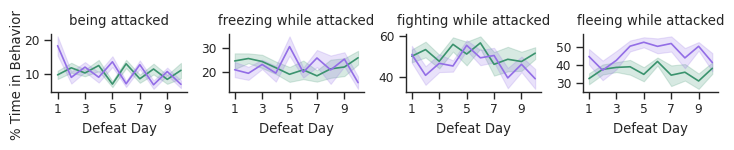

                               GEE Regression Results                              
Dep. Variable:                           t   No. Observations:                  200
Model:                                 GEE   No. clusters:                       20
Method:                        Generalized   Min. cluster size:                  10
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                10.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Sat, 18 May 2024   Scale:                          31.525
Covariance type:                    robust   Time:                         12:43:30
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.2511      0.604     16.965      0.000       9.067      11.435
si     

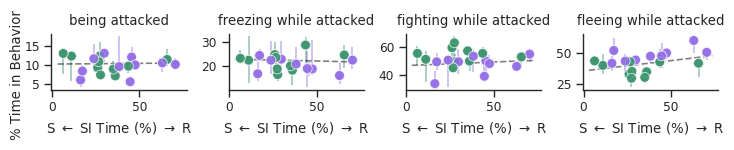

In [38]:
# b2tdict={'attack':'being attacked',
#      'standing against wall':'standing against wall',
#      'fightback':'fighting',
#      'runaway':'fleeing',
#      'sniffing':'being investigated',
#      'freezing':'immobile',
#      'approach':'approaching aggressor',
#      'fightWhenAttacked':'fighting while attacked',
#      'fightWhenNotAttacked': 'fighting while not attacked',
#      'notAttackedWhenFight':'not attacked while fighting',
#       'fleeWhenAttacked':'fleeing while attacked',
#      'freezeWhenAttacked':'immobile while attacked',
#       'fleeWhenSniffed':'fleeing while sniffed',
#      'freezeWhenSniffed':'immobile while sniffed',
#       'fightWhenSniffed':'fighting while sniffed',
#        'fleeWhenNotAttackedOrSniffed':'fleeing while not attacked or sniffed',
#      'freezeWhenNotAttackedOrSniffed':'immobile while not attacked or sniffed',
#       'fightWhenNotAttackedOrSniffed':'fighting while not attacked or sniffed',
#         'attackWhenNotFightOrFlee':'not fighting or fleeing while attacked',
#      'fightToFleeRatio': 'fight vs flee'}
b2tdict={'a':'being attacked',
     #'attack':'attacked2',
     'w':'standing against wall',
     'f':'fightback',
     'x':'runaway',
     's':'being investigated',
     #'sniffing':'sniffed2',
     'z':'freezing',
     'e':'approach',
     'i':'investigate aggressor',
     't':'tail rattle',
     'r':'rattle',
     'b':'barrier',
     'd':'defense',
     'p':'pursued',
     'u':'vigilant',
     'freezeWhenAttacked':'freezing while attacked',
     'fightWhenAttacked':'fighting while attacked',
     'fleeWhenAttacked':'fleeing while attacked'}

#border=['z','u','f','x']
border=['a','freezeWhenAttacked','fightWhenAttacked','fleeWhenAttacked']
#border=['attack','sniffing','fightWhenAttacked','fleeWhenAttacked']
rf_df_plot=rf_df
rf_df_plot['c']=[b2tdict[b] for b in rf_df_plot.b.values]
rf_df_plot['si']= [SI_values_NpHr[i] for i in rf_df_plot.r2s.values]
rf_df_plot=rf_df_plot.query('b in %s'%(border))
rf_df_plot['t']=rf_df_plot['t']*100
rf_df_plot['sex']='male'

rf_summary=make_behavior_plots(rf_df_plot,offset=0.5,order=[b2tdict[b] for b in border],
                    ylabel='% Time in Behavior',aspect=0.83,height=1.5)

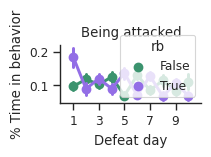

In [47]:
fig, axes = plt.subplots(1, 1, figsize=(2.2, 1.5), sharey=False)
sns.pointplot(data=rf_df.loc[(rf_df['b']=='a')], x="d", y="t", hue="rb",ci=68,palette=pal2,markersize=20,legend=False,)
plt.xlabel('Defeat day')
plt.ylabel('% Time in behavior',va='bottom')
plt.xticks(np.arange(0,10,step=2))
plt.xlim(-1,10)
plt.title('Being attacked')
sns.despine()
plt.savefig('rf_attackvsday_nphr.pdf',transparent=True,dpi=300,
                    bbox_inches='tight')

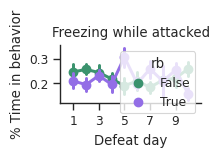

In [48]:
fig, axes = plt.subplots(1, 1, figsize=(2.2, 1.5), sharey=False)
sns.pointplot(data=rf_df.loc[(rf_df['b']=='freezeWhenAttacked')], x="d", y="t", hue="rb",ci=68,palette=pal2,markersize=20,legend=True,)
plt.xlabel('Defeat day')
plt.ylabel('% Time in behavior',va='bottom')
plt.xticks(np.arange(0,10,step=2))
plt.xlim(-1,10)
plt.title('Freezing while attacked')
sns.despine()
plt.savefig('rf_freezevsday_NpHr.pdf',transparent=True,dpi=300,
                    bbox_inches='tight')

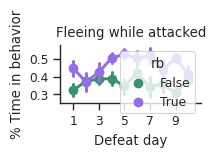

In [49]:
fig, axes = plt.subplots(1, 1, figsize=(2.2, 1.5), sharey=False)
sns.pointplot(data=rf_df.loc[(rf_df['b']=='fleeWhenAttacked')], x="d", y="t", hue="rb",ci=68,palette=pal2,markersize=20,legend=True,)
plt.xlabel('Defeat day')
plt.ylabel('% Time in behavior',va='bottom')
plt.xticks(np.arange(0,10,step=2))
plt.xlim(-1,10)
plt.title('Fleeing while attacked')
sns.despine()
plt.savefig('rf_fleevsday_NpHr.pdf',transparent=True,dpi=300,
                    bbox_inches='tight')

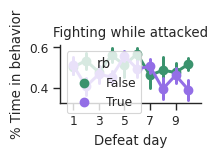

In [50]:
fig, axes = plt.subplots(1, 1, figsize=(2.2, 1.5), sharey=False)
sns.pointplot(data=rf_df.loc[(rf_df['b']=='fightWhenAttacked')], x="d", y="t", hue="rb",ci=68,palette=pal2,markersize=20,legend=True,)
plt.xlabel('Defeat day')
plt.ylabel('% Time in behavior',va='bottom')
plt.xticks(np.arange(0,10,step=2))
plt.xlim(-1,10)
plt.title('Fighting while attacked')
sns.despine()
plt.savefig('rf_fightvsday_NpHr.pdf',transparent=True,dpi=300,
                    bbox_inches='tight')

In [112]:
# rf_totals_df=pd.DataFrame(rf_totals)
# plt.figure(figsize=(20,3))
# sns.catplot(data=rf_totals_df.loc[(rf_totals_df['b']=='freezeWhenAttacked')], x="d", y="t", hue="rb", kind="bar",ci=68)
# #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xlabel('days')
# plt.ylabel('% fight')

# # plt.savefig('#attacks.pdf',transparent=True,dpi=300,
# #                    bbox_inches='tight')

In [78]:
## t-SNE
#saved=pickle.load(open('tsne_2101.p','rb'))
#saved=pickle.load(open('/jukebox/witten/Anna/fig_data_plotting_code/QuantifyingDefeat-main/QuantifyBehavior/t-sne_model.p','rb'))
saved=pickle.load(open('t-sne_model.p','rb'))
mlp2=saved['projection']
labeled_map=saved['map']
e2_test=saved['embeddings']

/usr/people/az3/.conda/envs/RF_anna/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [75]:
## t-SNE parameters
## Anna: from FP data

# average distance between mice
# tsne_dists=[229.70494978266953,
#  245.55505578548951,
#  245.12842340146145,
#  166.58055751288933,
#  149.51097837985458,
#  250.90124233870606,
#  226.49122360206243,
#  141.3280762786305,
#  96.60278218737608,
#  128.60567565443952,
#  93.26928011218547,
#  175.86329471200276,
#  89.84951112059038,
#  90.04663779430373,
#  203.50069251536658,
#  57.43254248517057,
#  123.0666217373827,
#  92.19272510334693]

# average distance between mice
tsne_dists=[232.90686263690472,
 185.6917293594533,
 202.02764425305966,
 465.0162008921633,
 284.04031362770564,
 213.77351374341595,
 316.38760347802116,
 375.0348620449249,
 306.53549848676846,
 406.49363078805675,
 470.8613266502949,
 191.68955682582188,
 284.0088259717928,
 354.44988764641107,
 485.7480468390343,
 370.8933914224106,
 528.1325273305198]

# dimensions of 2D histogram over t-SNE space
map_shape=(50,50)

# location in 50,50 histogram where the cluster peaks are
peakx=[5, 13, 14, 17, 18, 22, 23, 25, 27, 30, 31, 33, 35, 35, 37, 39, 43]
peaky=[23, 12, 19, 41, 32, 9, 32, 23, 15, 17, 44, 9, 11, 25, 35, 19, 28]

# Mapping from continuous 2D t-SNE space to histogram boundaries originally defined by photometry study
# Anna: print out from my code
xe,ye=(np.array([-61.84045874, -59.44965165, -57.05884455, -54.66803746, -52.27723037,
                -49.88642327, -47.49561618, -45.10480909, -42.714002,   -40.3231949,
                -37.93238781, -35.54158072, -33.15077362, -30.75996653, -28.36915944,
                -25.97835234, -23.58754525, -21.19673816, -18.80593106, -16.41512397,
                -14.02431688, -11.63350979,  -9.24270269,  -6.8518956,   -4.46108851,
                -2.07028141,   0.32052568,   2.71133277,   5.10213987,   7.49294696,
                9.88375405,  12.27456114,  14.66536824,  17.05617533,  19.44698242,
                21.83778952,  24.22859661,  26.6194037,   29.0102108,   31.40101789,
                33.79182498,  36.18263207,  38.57343917,  40.96424626,  43.35505335,
                45.74586045,  48.13666754,  50.52747463,  52.91828173,  55.30908882,
                57.69989591]),
 np.array( [-62.86710643, -60.38971776, -57.91232908, -55.43494041, -52.95755173,
             -50.48016306, -48.00277438, -45.52538571, -43.04799703, -40.57060836,
             -38.09321968, -35.61583101, -33.13844233, -30.66105366, -28.18366498,
             -25.70627631, -23.22888763, -20.75149896, -18.27411028, -15.79672161,
             -13.31933293, -10.84194426,  -8.36455558,  -5.88716691,  -3.40977823,
              -0.93238956,   1.54499912,   4.02238779,   6.49977647,   8.97716514,
              11.45455382,  13.93194249,  16.40933117,  18.88671984,  21.36410852,
              23.84149719,  26.31888587,  28.79627454,  31.27366322,  33.75105189,
              36.22844057,  38.70582924,  41.18321792,  43.66060659,  46.13799527,
              48.61538394,  51.09277262,  53.57016129,  56.04754997,  58.52493864,
              61.00232732]))

In [76]:
start_defeat = 5*60*FS
stop_defeat = 10*60*FS

In [71]:
import pickle
#pickle.dump(embeddings_all, open("embeddings_all.p","wb"))
embeddings_all= pickle.load(open('embeddings_all.p','rb'),encoding='latin')

In [79]:
xmin=min(xe)
xmax=max(xe)
ymin=min(ye)
ymax=max(ye)
labels_all={}
for k,e in embeddings_all.items():

    def to_coords(xy):
        
        x = (xy[0] - xmin) / (xmax - xmin) * map_shape[0]
        y = (xy[1] - ymin) / (ymax - ymin) * map_shape[1]
        if x >= map_shape[0]:
            x = map_shape[0]-1
        if y >= map_shape[1]:
            y = map_shape[1]-1
        if x < 0:
            x=0
        if y < 0:
            y=0
        return int(x), int(y)
    labels_all[k] = np.array([labeled_map[to_coords(point)] for point in e])

In [116]:
## Laser stim data
# import pre-processed data
from scipy.io import loadmat
mice = r2s_NpHr

#filename='/jukebox/witten/Anna/Social_Defeat/Opto/NpHr/stim_info_NpHr.mat'
filename='stim_info_NpHr.mat'
struct = loadmat(filename)

for i,m in enumerate(mice):
    for d in range (1,11):
        alldat_nphr[(m,d)]['laser_on'] = struct['stim_info']['all_stim_square_downsampled'][0][0][i][d-1].T[0]

In [80]:
## for all mice
def heatmap(data, axlims=None, bins=100, normed=True, sigma=0.0):
    from scipy.ndimage.filters import gaussian_filter
    # Initial histogram
    heatmap, xedges, yedges = np.histogram2d(data[:,0], data[:, 1],
            bins=bins, range=axlims, normed=normed)
    # Convolve with Gaussian
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    return heatmap,xedges,yedges

hists_all = {}
for test_key in embeddings_all:
    embedded_mlp=embeddings_all[test_key]
    z,_,_ = heatmap(embedded_mlp, bins=(xe,ye), sigma=1.5)
    hists_all[test_key]=z/z.sum()

In [81]:
## for all mice
hists_stim_all={}
for g in groups:
    for m in groups[g]:
        for d in range(1,11):
            k= (m,d)
            #print(k)
            if k not in alldat_all or 'laser_on' not in alldat_all[k]:
                continue
            #s=alldat[k]['laser_on']>1
            s=alldat_all[k]['laser_on'][start_defeat:stop_defeat]>0
            embedded_mlp=embeddings_all[k]
            if len(s)!=len(embedded_mlp):
                continue
            z,_,_ = heatmap(embedded_mlp[s], bins=(xe,ye), sigma=1.5)
            z2,_,_ = heatmap(embedded_mlp, bins=(xe,ye), sigma=1.5)
            hists_stim_all[k]=(z/z.sum())

/usr/people/az3/.conda/envs/RF_anna/lib/python3.7/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


Align stimulation to behavior in t-SNE space

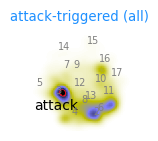

In [253]:
sns.set_style('dark')
#o2title={'closed-loop':'fight-triggered','open-loop':'open-loop','no opsin control':'no opsin control'}
#o2title={'vglut':'attack-triggered','wt':'attack-triggered','no opsin control':'no opsin control','no light control':'no light control'}
o2title={'vglut all':'attack-triggered (all)','no opsin control all':'no opsin control (all)'}
#fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(8,3))
plt.figure(figsize=(4,1.5))
for i,g in enumerate(pord):
    if i == 1:
        continue

    resilient_map=np.zeros(hists_all[(663,1)].shape)
    for m in groups[g]:

        for d in range(1,11):
            if (m,d) in hists_stim_all:
                resilient_map += hists_stim_all[(m,d)]/np.sum(hists_all[(m,d)])
    resilient_map=resilient_map/resilient_map.sum()
    #im=axs[i].imshow(resilient_map.T,origin='lower',cmap='gist_stern_r',vmin=0,vmax=0.005)
    im=plt.imshow(resilient_map.T,origin='lower',cmap='gist_stern_r',vmin=0,vmax=0.005)
    plt.axis('off')
    plt.title(o2title[g],color=ppal[i])
    for j in np.unique((labeled_map).flatten()):
        x=peakx[int(j)-1]
        y=peaky[int(j)-1]
        if np.where(np.argsort(tsne_dists)==int(j)-1)[0][0]+1 != 1:
            plt.text(x,y,np.where(np.argsort(tsne_dists)==int(j)-1)[0][0]+1,size=7,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color='grey')
        else:
            plt.text(x,y,'attack',size=10,
                    verticalalignment='center',
                    horizontalalignment='center',
                    color='black')
cbar=fig.colorbar(im,fraction=0.048,orientation='vertical',pad=-0.04)
cbar.set_ticks([])
#fig.subplots_adjust(wspace=0, hspace=0)
cbar.set_label('Hi  $P$(Stim)   Lo',rotation=-90,va='bottom')

# # plt.show()
# plt.savefig('opto_tSNE_all.pdf',transparent=True,dpi=300,
#                     bbox_inches='tight')

In [11]:
## Laser stim data (cohort 2)
# import pre-processed data
import mat73

from scipy.io import loadmat
mice = [660,
662,
663,
664,
674,
676,
677,
678,
679,
681,
684,
685,
686,
687,
688]

#filename='/jukebox/witten/Anna/Social_Defeat/Opto/vglut_cohort2/opto_mice.mat'
#filename='/jukebox/witten/Anna/Social_Defeat/Opto/vglut_cohort2/stim_latencies_vglut2_square.mat'
filename='stim_latencies_vglut2_square.mat'
#struct = loadmat(filename)
struct = mat73.loadmat(filename)

for i,m in enumerate(mice):
    for d in range (1,11):
#         alldat_all[(m,d)]['laser_on'] = struct['stim_info']['all_stim_square'][0][0][i][d-1].T[0]
         alldat_all[(m,d)]['laser_on'] = struct['stim_info']['all_stim_square_downsampled'][i][d-1].T

In [12]:
## Laser stim data (cohort 1)
# import pre-processed data
#import mat73

#from scipy.io import loadmat
mice = [621,
622,
624,
627,
636,
640,
644]

#filename='/jukebox/witten/Anna/Social_Defeat/Opto/vglut_cohort1/stim_latencies_vglut1_square.mat'
filename='stim_latencies_vglut1_square.mat'
struct = loadmat(filename)
#struct = mat73.loadmat(filename)

for i,m in enumerate(mice):
    for d in range (1,11):
        alldat_all[(m,d)]['laser_on'] = struct['stim_info']['all_stim_square_downsampled'][0][0][i][d-1].T[0]
        #alldat_all[(m,d)]['laser_on'] = struct['stim_info']['all_stim_square_downsampled'][i][d-1].T[0]

In [147]:
FS=100
sparse_time = 1
start_defeat = 5*60*FS
stop_defeat = 10*60*FS
# starts_all = {}
# sparse_starts_all = {}
for behavior in ['close proximity']:
    preattack2lhb={}
    postattack2lhb={}
    preXs={}
    postXs={}
    span=10*FS
    sns.set_style("ticks")

    for m in r2s_all:
#    for m in mice:
#         if m in BAD_LHb:
#             continue
        ims={('LHb','onset'):[],
             ('LHb','offset'):[]}
        for d in range(1,11):
            k=(m,d)
#             if m in BAD_LHb:
#                 continue
#             if k in BAD_SESSIONS:
#                 continue
            #if k not in rf_scores or 'fp_lhb_samp' not in alldat[k]:
#            if k not in rf_scores_freezing_BOTH_new or 'laser_on' not in alldat_all[k]:
            if k not in rf_scores_OPTO_BOTH_new or 'laser_on' not in alldat_all[k]:
                continue
                
#             starts_all[k] = {}
#             sparse_starts_all[k] = {}
            
            #attack=(alldat[k]['body_part_tracking']['TopBetweenCentroidDistance']<120).astype(int)#SHOULD BE 120 #Anna: change to 5 as it is in cm
            #attack=(rf_scores_freezing_BOTH_new[k]['a']==True).astype(int)#SHOULD BE 120 #Anna: change to 5 as it is in cm
            attack=(rf_scores_OPTO_BOTH_new[k]['a']==True).astype(int)#SHOULD BE 120 #Anna: change to 5 as it is in cm
            #attack=(rf_scores_freezing_BOTH_new[k]['a']==True).astype(int)#SHOULD BE 120 #Anna: change to 5 as it is in cm
            #attack=(rf_scores_opto_old[k]['a']==True).astype(int)#SHOULD BE 120 #Anna: change to 5 as it is in cm

            if not np.sum(attack):
                continue
            starts = np.where(attack[1:]-attack[:-1]==1)[0]
            starts = starts[starts>start_defeat]
            starts = starts[starts<stop_defeat]
            #sparser_starts = starts[np.concatenate((np.diff(starts)>FS*5,[True]))]
            sparse_starts= [a for i,a in enumerate(starts) if np.sum(attack[a-FS*sparse_time:a])==0]
            #sparse_starts= [a for i,a in enumerate(sparser_starts) if np.sum(attack[a-FS:a])==0]
            #sparse_starts = starts
            
            #starts_all[k] = starts
            #sparse_starts_all[k] = sparse_starts

            ends = np.where(attack[:-1]-attack[1:]==1)[0]
            ends = ends[ends>start_defeat]
            ends = ends[ends<stop_defeat]
            #sparser_ends = starts[np.concatenate(([np.diff(ends)[0]>FS*5],np.diff(ends)>FS*5))]
            sparse_ends= [a for i,a in enumerate(ends) if np.sum(attack[a+1:a+FS*sparse_time])==0]
            #sparse_ends= [a for i,a in enumerate(sparser_ends) if np.sum(attack[a+1:a+FS*5])==0]
            #sparse_ends = ends

            before=np.array([(np.arange(start-span,start+span)).astype(int) for start in sparse_starts if (start+span)<len(alldat_all[k]['laser_on'])])
            after=np.array([(np.arange(end-span,end+span)).astype(int) for end in sparse_ends if end-span>0 and (end+span)<len(alldat_all[k]['laser_on'])])
            
            #before_all[k] = before
            #after_all[k] = after
            
            if not len(before) or not len(after):
                continue
            #preattack2lhb[k]=[alldat[k]['fp_lhb_samp'][b]-alldat[k]['fp_lhb_samp'][b][:span].mean() for b in before]
            preattack2lhb[k]=[alldat_all[k]['laser_on'][b] for b in before]
            #postattack2lhb[k]=[alldat[k]['fp_lhb_samp'][a]-alldat[k]['fp_lhb_samp'][a][:span].mean() for a in after]
            postattack2lhb[k]=[alldat_all[k]['laser_on'][a] for a in after]

            preX=np.zeros((before.shape[0],before.shape[1]))
            postX=np.zeros((before.shape[0],before.shape[1]))
            
            ims[('LHb','onset')].append(preattack2lhb[k])
            ims[('LHb','offset')].append(postattack2lhb[k])
            

## Place into a dataframe
time = np.arange(span/FS*-1,span/FS,1/100)#np.arange(-2,2,1/100)

#attack_timecourse_onset = {'m':[],'d':[],'t':[],'onset':[],'r2s':[],'rb':[]}
attack_timecourse_onset = {'m':[],'d':[],'t':[],'onset':[]}
for i,m in enumerate(r2s_all):
#for i,m in enumerate(mice):
    for d in range(1,11):
        k = (m,d)
        if k in preattack2lhb.keys(): 
            for trial in range(0,len(preattack2lhb[k])):
                for frame in range(0,len(preattack2lhb[k][0])):
                    attack_timecourse_onset['m'].append(m)
                    attack_timecourse_onset['d'].append(d)
                    attack_timecourse_onset['t'].append(time[frame])
                    attack_timecourse_onset['onset'].append(preattack2lhb[k][trial][frame])
                    #attack_timecourse_onset['r2s'].append(i)
                    #attack_timecourse_onset['rb'].append(i>=RFCUTOFF)
attack_timecourse_onset_df=pd.DataFrame(attack_timecourse_onset)

#attack_timecourse_offset = {'m':[],'d':[],'t':[],'offset':[],'r2s':[],'rb':[]}
attack_timecourse_offset = {'m':[],'d':[],'t':[],'offset':[]}
for i,m in enumerate(r2s_all):
#for i,m in enumerate(mice):
    for d in range(1,11):
        k = (m,d)
        if k in postattack2lhb: 
            for trial in range(0,len(postattack2lhb[k])):
                for frame in range(0,len(postattack2lhb[k][0])):
                    attack_timecourse_offset['m'].append(m)
                    attack_timecourse_offset['d'].append(d)
                    attack_timecourse_offset['t'].append(time[frame])
                    attack_timecourse_offset['offset'].append(postattack2lhb[k][trial][frame])
                    #attack_timecourse_offset['r2s'].append(i)
                    #attack_timecourse_offset['rb'].append(i>=RFCUTOFF)
attack_timecourse_offset_df=pd.DataFrame(attack_timecourse_offset)

## Average across all events and days at once (per mouse)
#attack_timecourse_events = {'m':[],'t':[],'onset':[],'offset':[],'r2s':[],'rb':[]}
attack_timecourse_events = {'m':[],'t':[],'onset':[],'offset':[]}
for i,m in enumerate(r2s_all):
#for i,m in enumerate(mice):
    if m in preattack2lhb:
        mouse_alldays_onset = []
        mouse_alldays_offset = []
        mouse_alldays_onset_concat = []
        mouse_alldays_offset_concat = []
        for d in range(1,11):
            k = (m,d)
            #if k not in BAD_SESSIONS and k != (3810,9):
            #if k not in BAD_SESSIONS:
            mouse_alldays_onset.append(np.array(preattack2lhb[k][:]))
            mouse_alldays_offset.append(np.array(postattack2lhb[k][:]))
        mouse_alldays_onset_concat =  mouse_alldays_onset[0]
        mouse_alldays_offset_concat =  mouse_alldays_offset[0]
        for session in range(1,len(mouse_alldays_onset)):
            mouse_alldays_onset_concat =np.concatenate((mouse_alldays_onset_concat,mouse_alldays_onset[session]))
            mouse_alldays_offset_concat =np.concatenate((mouse_alldays_offset_concat,mouse_alldays_offset[session]))                
        mouse_alldays_onset_avg = np.mean(mouse_alldays_onset_concat,0) #average across all sessions and all days at once
        mouse_alldays_offset_avg = np.mean(mouse_alldays_offset_concat,0) #average across all sessions and all days at once

        # place into dataframe        
        for frame in range(0,len(time)):
            attack_timecourse_events['m'].append(m)
            attack_timecourse_events['t'].append(time[frame])
            attack_timecourse_events['onset'].append(mouse_alldays_onset_avg[frame])
            attack_timecourse_events['offset'].append(mouse_alldays_offset_avg[frame])
            #attack_timecourse_events['r2s'].append(i)
            #attack_timecourse_events['rb'].append(i>=RFCUTOFF)
attack_timecourse_events_df=pd.DataFrame(attack_timecourse_events)

## Average across day (per mouse)
#attack_timecourse_day_avged = {'m':[],'d':[],'t':[],'onset':[],'offset':[],'r2s':[],'rb':[]}
attack_timecourse_day_avged = {'m':[],'d':[],'t':[],'onset':[],'offset':[]}
for i,m in enumerate(r2s_all):
#for i,m in enumerate(mice):
    #if m not in BAD_LHb:
    for d in range(1,11):
        mouse_dayavg_onset = []
        mouse_dayavg_offset = []
        k = (m,d)
        #if k not in BAD_SESSIONS and k != (3810,9):
        if k in preattack2lhb:
            mouse_dayavg_onset.append(np.mean(preattack2lhb[k],0))
            mouse_dayavg_offset.append(np.mean(postattack2lhb[k],0))
            for frame in range(0,len(time)):
                attack_timecourse_day_avged['m'].append(m)
                attack_timecourse_day_avged['d'].append(d)
                attack_timecourse_day_avged['t'].append(time[frame])
                attack_timecourse_day_avged['onset'].append(mouse_dayavg_onset[0][frame])
                attack_timecourse_day_avged['offset'].append(mouse_dayavg_offset[0][frame])
                #attack_timecourse_day_avged['r2s'].append(i)
                #attack_timecourse_day_avged['rb'].append(i>=RFCUTOFF)
attack_timecourse_day_avged_df=pd.DataFrame(attack_timecourse_day_avged)

## Average across day avgs to get one avg per mouse
#attack_timecourse_avged = {'m':[],'t':[],'onset':[],'offset':[],'r2s':[],'rb':[]}
attack_timecourse_avged = {'m':[],'t':[],'onset':[],'offset':[]}
for i,m in enumerate(r2s_all):
#for i,m in enumerate(mice):
    #if m not in BAD_LHb:
    mouse_dayavg_onset = []
    mouse_dayavg_offset = []
    for d in range(1,11):
        k = (m,d)
        #if k not in BAD_SESSIONS and k != (3810,9):
        if k in preattack2lhb:
            mouse_dayavg_onset.append(np.mean(preattack2lhb[k],0))
            mouse_dayavg_offset.append(np.mean(postattack2lhb[k],0))
    mouse_dayavg_onset_avg = np.mean(mouse_dayavg_onset,0)
    mouse_dayavg_offset_avg = np.mean(mouse_dayavg_offset,0)
# place into dataframe            
    for frame in range(0,len(time)):
        attack_timecourse_avged['m'].append(m)
        attack_timecourse_avged['t'].append(time[frame])
        attack_timecourse_avged['onset'].append(mouse_dayavg_onset_avg[frame])
        attack_timecourse_avged['offset'].append(mouse_dayavg_offset_avg[frame])
        #attack_timecourse_avged['r2s'].append(i)
        #attack_timecourse_avged['rb'].append(i>=RFCUTOFF)
attack_timecourse_avged_df=pd.DataFrame(attack_timecourse_avged)

## Average across all mice to get peaks
attack_timecourse_avged_overall = {'t':[],'onset':[],'offset':[]}
for frame in range(0,len(time)):
    attack_timecourse_avged_overall['t'].append(time[frame])
    attack_timecourse_avged_overall['onset'].append(attack_timecourse_day_avged_df.loc[attack_timecourse_day_avged['t']==time[frame], 'onset'].mean())
    attack_timecourse_avged_overall['offset'].append(attack_timecourse_day_avged_df.loc[attack_timecourse_day_avged['t']==time[frame], 'offset'].mean())
attack_timecourse_avged_overall_df=pd.DataFrame(attack_timecourse_avged_overall)

NameError: name 'rf_scores_OPTO_BOTH_new' is not defined

[[<matplotlib.axis.XTick at 0x7f051745e910>,

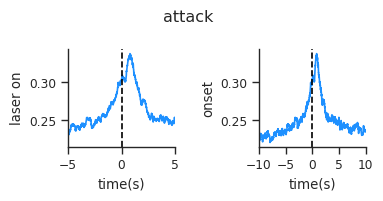

In [36]:
## all mice
fig, axes = plt.subplots(1, 2, figsize=(4, 2), sharey=False)
fig.suptitle('attack')

mouse = 644

sns.lineplot(ax=axes[0],data=attack_timecourse_avged_overall_df, x='t', y='onset', ci=68,color='DodgerBlue')
axes[0].set_xlabel('time(s)')
axes[0].set_ylabel('laser on',va='bottom')
#axes[0].set_title(mouse)
axes[0].axvline(x=0,color='k',linestyle='--')
axes[0].set(xlim=(-5, 5))
#axes[0].set(ylim=(.122, .22))
sns.despine()

sns.lineplot(ax=axes[1],data=attack_timecourse_avged_overall_df, x='t', y='onset', ci=68,color='DodgerBlue')
axes[1].set_xlabel('time(s)')
#axes[1].set_ylabel('Mean $\Delta$F/F (Z)',va='bottom')
#axes[1].set_title(mouse)
axes[1].axvline(x=0,color='k',linestyle='--')
axes[1] = plt.gca()
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set(xlim=(-10, 10))
axes[1].set(xticks=range(-10, 11, 5))
#axes[1].set(ylim=(.122, .22))
#plt.title('offset')

# plt.savefig('laser_timelock_long.pdf',transparent=True,dpi=300,
#                     bbox_inches='tight')

# plt.savefig('644_2.pdf',transparent=True,dpi=300,
#                     bbox_inches='tight')